In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats

# Functions

In [24]:
def columns_categories(df):
    '''
    Input:
    ------
    df : dataframe
    
    Output:
    -------
    continuous : continuous variables list
    categorical : categorical variables list
    '''
    continuous = []
    categorical = []
    count = 0
    for column in df.columns:
        if df.dtypes[count] == 'object':
            categorical.append(df.columns[count])
            count += 1
        
        elif df.dtypes[count] == 'int64':
            continuous.append(df.columns[count])
            count += 1
            
        else:
            print('Column type not recognized')
            count += 1
            
    return continuous, categorical

In [25]:
def describe_continuous(df, col_list):
    '''
    Input:
    ------
    df = name of the dataframe
    col_list = list of continuous variables
    
    Output:
    -------
    Printing mean, std, quartiles, outliers values and size
    '''
    for col in col_list:
        print(col + ' :')
        print('Mean = ' + str(df[col].mean()))
        print('Std = ' + str(df[col].std()))
        Q1=df[col].quantile(0.25)
        Q2=df[col].quantile(0.5)
        Q3=df[col].quantile(0.75)
        IQR=Q3-Q1
        print(f'First quartile = {Q1}')
        print(f'Median = {Q2}')
        print(f'Third quartile = + {Q3}')
        print(f'Outliers = {Q1-1.5*IQR}<= ({len(df.loc[df[col] <= Q1-1.5*IQR].index)} lines) & =>{Q3+1.5*IQR} ({len(df.loc[df[col] >= Q3+1.5*IQR].index)} lines)')
        print('------------------------------------------------')
        print('')

In [26]:
def custom_stratified_train_test_split(dataframe, y, columns_to_drop=[]):
    '''
    Input:
    ------
    dataframe : dataframe
    y (string) : target variable name
    columns_to_drop (list) (optional) : list of columns to drop if there is
    
    Output:
    -------
    The X_train, y_train, X_test, y_test
    '''
    
    df = dataframe.drop(columns_to_drop, axis=1).sample(len(dataframe))
    
    columns = [x for x in df.columns]
    y_value_list = [x for x in df[y].unique()]
    
    train = pd.DataFrame(columns = columns)
    test = pd.DataFrame(columns = columns)
    
    for value in y_value_list :
        temp_df = df.loc[df[y] == value]
        third = round(len(temp_df)/3)
        train = pd.concat([train, temp_df[third:]], ignore_index=True)
        test = pd.concat([test, temp_df[:third]], ignore_index=True)
    
    X_train = train.drop([y], axis=1)
    X_test = test.drop([y], axis=1)
    y_train = train[y].astype('int')
    y_test = test[y].astype('int')
    
    return X_train, X_test, y_train, y_test

In [27]:
def testing_logistic_regression(df, X_train, X_test, y_train, y_test):
    '''
    Input:
    ------
    df : dataframe
    X : dataframe with variables
    y : target variable
    
    Output:
    -------
    prints logistic regression score, confusion matrix and feature importance
    '''
    
    logreg = LogisticRegression(max_iter=100000, random_state=0)
    logreg.fit(X_train, y_train)
    print(f'Logistic regression accuracy : {logreg.score(X_test, y_test)}')
    
    CM = confusion_matrix(y_test, logreg.predict(X_test))

    sns.heatmap(CM, annot=True)
    plt.show()
    
    w = logreg.coef_[0]
    feature_importance = pd.DataFrame(X_test.columns, columns = ["feature"])
    feature_importance["importance"] = pow(math.e, w)
    feature_importance = feature_importance.sort_values(by = ["importance"], ascending=True).tail(20)
 
    ax = feature_importance.plot.barh(x='feature', y='importance')
    plt.show()

In [28]:
def testing_random_forest(X_train, X_test, y_train, y_test):
    '''
    Output:
    -------
    prints random forest score, plots confusion matrix, and plots feature importance
    '''
    
    rforest = RandomForestClassifier(random_state=0)
    rforest.fit(X_train, y_train)
    print(f'Random forest score : {rforest.score(X_test, y_test)}')
    CM = confusion_matrix(y_test, rforest.predict(X_test))

    sns.heatmap(CM, annot=True)
    plt.show()

    feat_importances = pd.Series(rforest.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(20).sort_values().plot(kind='barh')

In [29]:
def testing_KNN(X_train, X_test, y_train, y_test):
    
    KNN = KNeighborsClassifier()
    KNN.fit(X_train, y_train)
    
    print(f'KNN accuracy : {metrics.accuracy_score(y_test, KNN.predict(X_test))}')
    
    CM = confusion_matrix(y_test, KNN.predict(X_test))

    sns.heatmap(CM, annot=True)
    plt.show()

# Data preparation

In [30]:
#Importing the original csv
original = pd.concat([pd.read_csv('student-mat.csv'), pd.read_csv('student-por.csv')], ignore_index=True)\
            .drop_duplicates(["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"])

In [31]:
#Renaming variables for readability (I prefer long and explicit names rather than short cryptic names) and processing purpose (see next cell)
renamed = original.rename(columns = {"school" : "school_GP",
                          "sex" : "female",
                          "age" : "age",
                          "address" : "urban",
                          "famsize" : "family_more_than_3",
                          "Pstatus" : "parents_living_together",
                          "Medu" : "mother_edu",
                          "Fedu" : "father_edu",
                          "Mjob" : "mother_job",
                          "Fjob" : "father_job",
                          "reason" : "school_motivation",
                          "guardian" : "guardian",
                          "traveltime" : "traveltime",
                          "studytime" : "studytime",
                          "failures" : "failures",
                          "schoolsup" : "school_support",
                          "famsup" : "family_support",
                          "paid" : "paid_class",
                          "activities" : "activities",
                          "nursery" : "nursery_school",
                          "higher" : "wish_higher_education",
                          "internet" : "internet_at_home",
                          "romantic" : "romantic_relationship",
                          "famrel" : "family_relationship_quality",
                          "freetime" : "freetime_amount",
                          "goout" : "go_out_friends_frequency",
                          "Dalc" : "workday_alc_cons",
                          "Walc" : "weekend_alc_cons",
                          "health" : "health_status",
                          "absences" : "school_absences",
                          "G1" : "first_grades",
                          "G2" : "second_grades",
                          "G3" : "final_grades"})

In [32]:
#Replacing values of binary variables to make them readable by an algorithm, and one value from school_motivation I didn't find explicit
renamed['school_GP'] = renamed["school_GP"].replace('MS', '0').replace('GP', '1')
renamed['female'] = renamed["female"].replace('M', '0').replace('F', '1')
renamed["family_more_than_3"] = renamed["family_more_than_3"].replace('GT3', '0').replace('LE3', '1')
renamed["urban"] = renamed["urban"].replace('R', '0').replace('U', '1')
renamed["parents_living_together"] = renamed["parents_living_together"].replace('A', '0').replace('T', '1')
renamed["school_motivation"] = renamed["school_motivation"].replace('home', 'close')
renamed["school_support"] = renamed["school_support"].replace('no', '0').replace('yes', '1')
renamed["family_support"] = renamed["family_support"].replace('no', '0').replace('yes', '1')
renamed["paid_class"] = renamed["paid_class"].replace('no', '0').replace('yes', '1')
renamed["activities"] = renamed["activities"].replace('no', '0').replace('yes', '1')
renamed["nursery_school"] = renamed["nursery_school"].replace('no', '0').replace('yes', '1')
renamed["wish_higher_education"] = renamed["wish_higher_education"].replace('no', '0').replace('yes', '1')
renamed["internet_at_home"] = renamed["internet_at_home"].replace('no', '0').replace('yes', '1')
renamed["romantic_relationship"] = renamed["romantic_relationship"].replace('no', '0').replace('yes', '1')
renamed["father_teacher"] = np.where(renamed['father_job']=='teacher', '1', '0')
renamed["father_services"] = np.where(renamed['father_job']=='services', '1', '0')
renamed["father_health"] = np.where(renamed['father_job']=='health', '1', '0')
renamed["father_at_home"] = np.where(renamed['father_job']=='at_home', '1', '0')
renamed = renamed.drop(['father_job', 'mother_job'], axis=1)
renamed["school_reputation_motivation"] = np.where(renamed['school_motivation']=='reputation', '1', '0')
renamed = renamed.drop(['school_motivation'], axis=1)
renamed = renamed.drop(['guardian'], axis=1)

In [39]:
#Creating variables list for data exploration
#Putting every column into numerical type for later use of picky Python libraries (ignore the message)
continuous, categorical = columns_categories(renamed)
renamed = renamed.apply(pd.to_numeric)

# Data overview

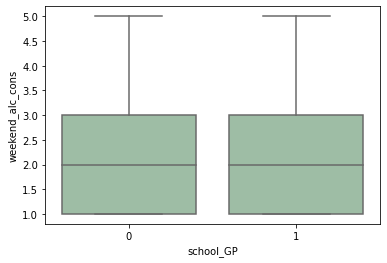

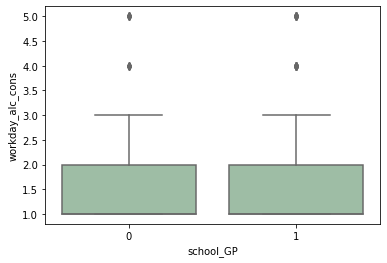

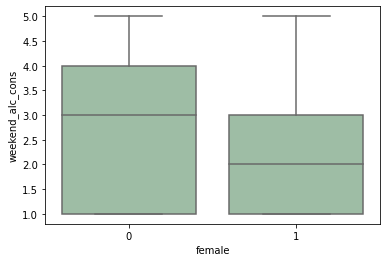

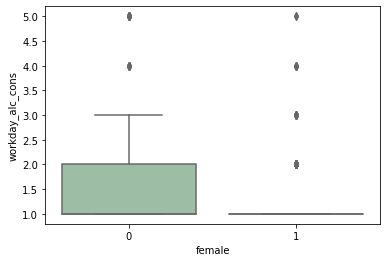

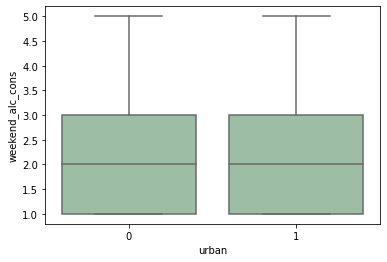

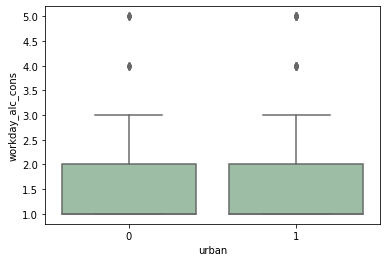

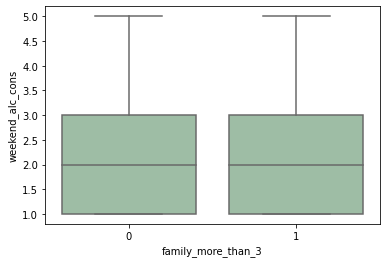

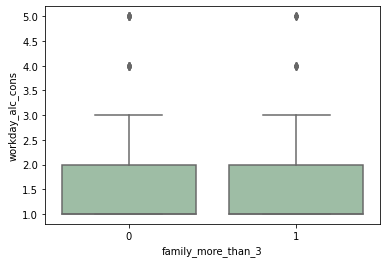

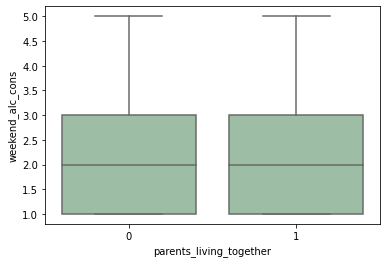

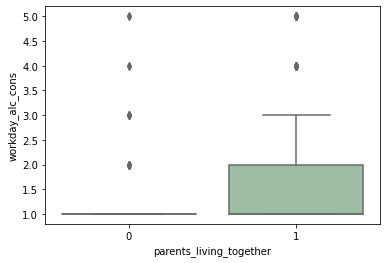

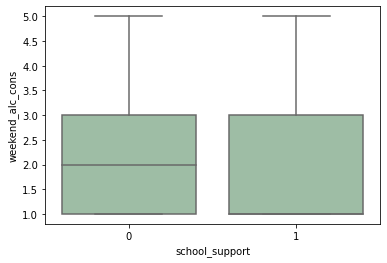

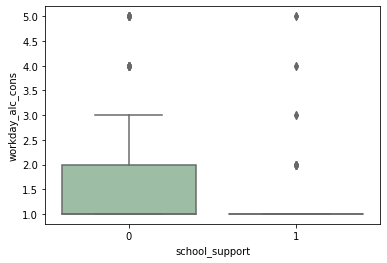

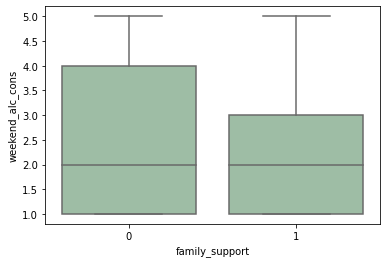

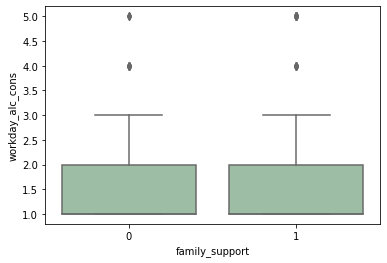

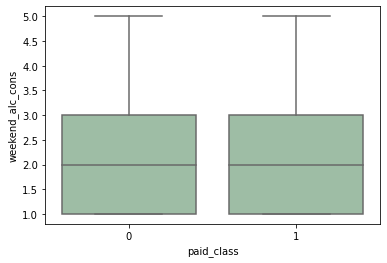

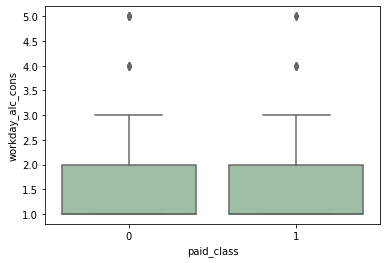

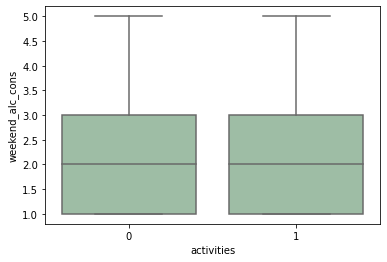

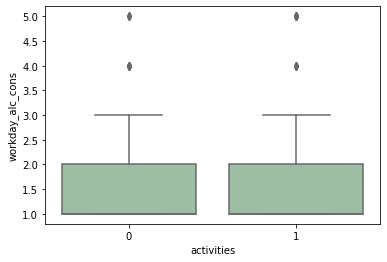

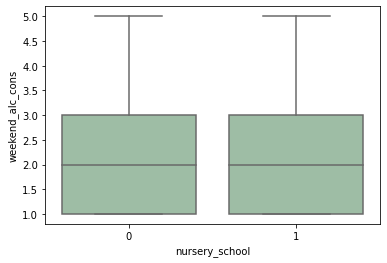

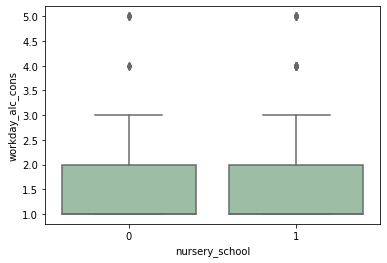

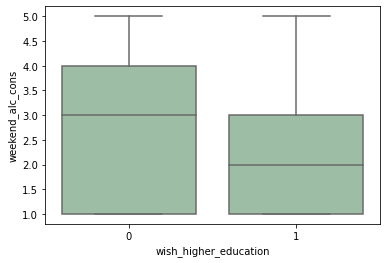

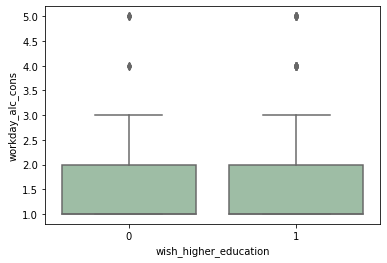

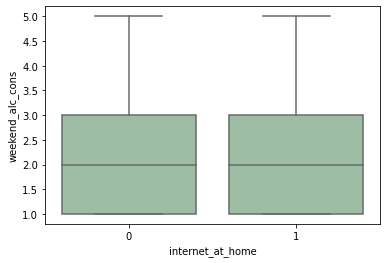

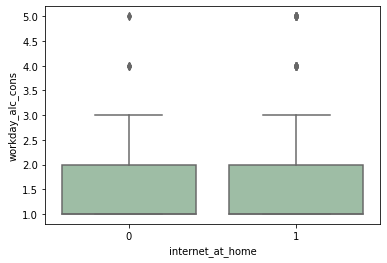

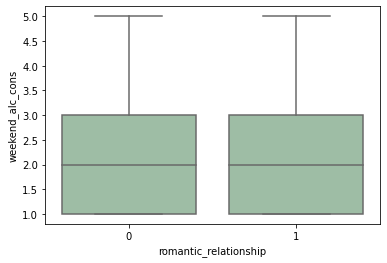

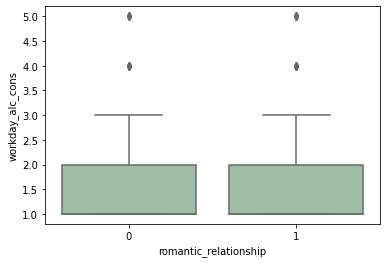

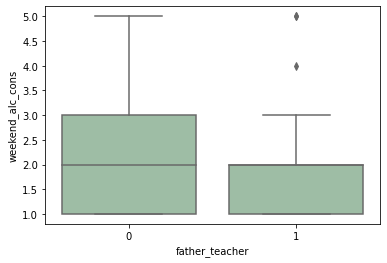

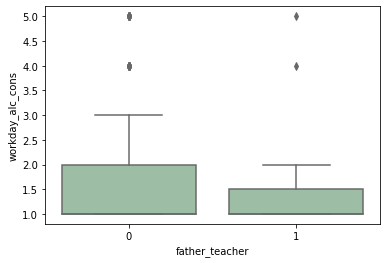

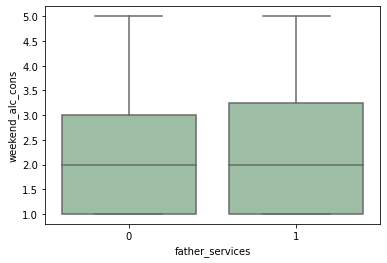

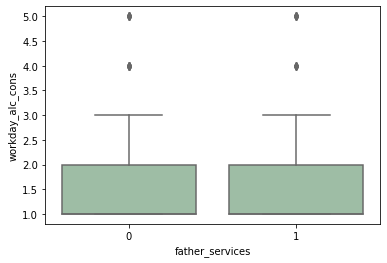

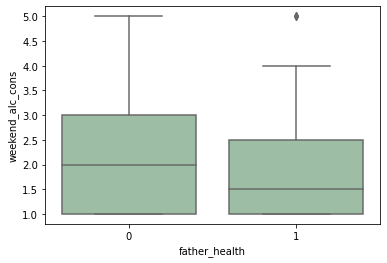

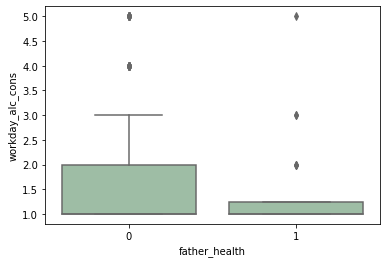

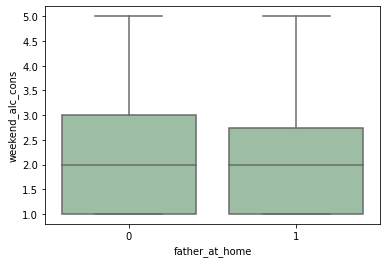

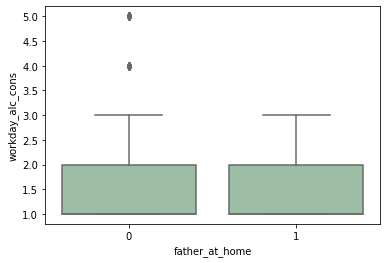

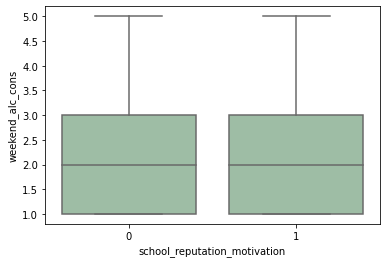

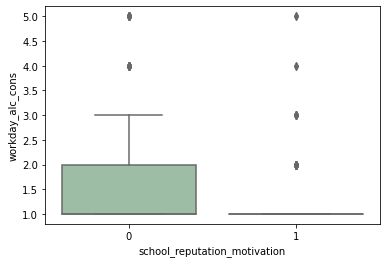

In [42]:
#In order to check which categorical variable can have an effect on alcohol consumption, I plotted all necessary boxplot
#Still, as most categories are very unbalanced, most of the effect have low reliability
#First, it's visible that while comparable, weekend and workday alcohol consumption don't act the same way.
#Therefore, both consumptions must be considered as distinct
#Generally speaking, alcohol consumption frequency is lower during workday than during weekdays
#School, urban, family size, paid_class, activities, nursery_school, internet_at_home, romantic_relationship, seems to have no effect
#Men drink more frequently than women, both during workday and weekend
#Students with families living together tend to drink less during weekend, but as much as the others during workdays
#Students with school support tend to drink less, escpexially during workdays
#Students without family support tend to drink more during weekend, but as much as the others during workdays
#Students that don't aim for higher education degrees tend to drink more during weekend, but as much as the others during workdays
#Students who have a father working as a teacher or in health-related fields tend to drink less than the others during both weekend and workdays
#Students with a father at home tend to drink less during the weekend, but just as much during workdays compared to the others
#Students (or students that had parents) that chose the school for its reputation tend to drink as much as the others during weekend, but almost not at all during workday

for variable in categorical:
    ax = sns.boxplot(x=renamed[variable], y=renamed['weekend_alc_cons'], color='#99c2a2')
    plt.show()

    ax = sns.boxplot(x=renamed[variable], y=renamed['workday_alc_cons'], color='#99c2a2')
    plt.show()

In [43]:
#Continuous data is rather homogenous. Very few outliers, except for failures (but it's due to the inapropriate way of calculating them for this precise variable)
#Very few lines have a really high workday alcohool consumption, but they are the most interesting ones for the analysis
describe_continuous(renamed, continuous)

age :
Mean = 16.812688821752264
Std = 1.269193588841573
First quartile = 16.0
Median = 17.0
Third quartile = + 18.0
Outliers = 13.0<= (0 lines) & =>21.0 (4 lines)
------------------------------------------------

mother_edu :
Mean = 2.4924471299093653
Std = 1.130957739906618
First quartile = 2.0
Median = 2.0
Third quartile = + 4.0
Outliers = -1.0<= (0 lines) & =>7.0 (0 lines)
------------------------------------------------

father_edu :
Mean = 2.293051359516616
Std = 1.0940272700234126
First quartile = 1.0
Median = 2.0
Third quartile = + 3.0
Outliers = -2.0<= (0 lines) & =>6.0 (0 lines)
------------------------------------------------

traveltime :
Mean = 1.5649546827794563
Std = 0.7427989637278066
First quartile = 1.0
Median = 1.0
Third quartile = + 2.0
Outliers = -0.5<= (0 lines) & =>3.5 (16 lines)
------------------------------------------------

studytime :
Mean = 1.9274924471299093
Std = 0.8274047037670186
First quartile = 1.0
Median = 2.0
Third quartile = + 2.0
Outliers = -0.5<=

In [45]:
#Here I outline the most interesting correlations (significant and at >.1 coefficient) which can give a first overview of the data
# Negative correlation with parents education and age (explained by the .25 correlation with failures)
# .64 correlation between both parents education
# Negative correlation between traveltime and parents education
# Negative correlation between failures and studytime
# Positive correlations between freetime amount, failures and family-relationship
# .33 correlation between going out with friends frequency and freetime amount
# Negative correlation between both acohol consumptions and studytime
# Positive correlation between both alcohol consumptions and age, but stronger for workday consumption
# Strong positive correlations (.25 and .4) between alcohol consumption and going out with friends frequency
# .62 correlation between the two types of alcohol consumptions
# Positive correlation between family relationship quality and health status
# Positive correlation between health status and weekend alcohol consumption
# Positive correlation of school absences with age and both alcohol consumptions
# Very strong correlation between the 3 grades (.84, .8 and .91) and very similar correlations with the other variables. I'll merge them and redo the analysis for this variable
# -.13 correlation between mean grades and age
# .21 and .17 correlation between mother and father education level respectively and mean grades
# .13 correlation between mean grades and study time
# -.38 correlation between mean grades and previous failures
# -.09 slight correlation between mean grades and workday alcohol consumption
# -.11 correlation between mean grades and weekend alcohol consumption
renamed['mean_grades'] = renamed[['first_grades', 'second_grades', 'final_grades']].mean(axis=1)
renamed = renamed.drop(['first_grades', 'second_grades', 'final_grades'], axis=1)
continuous_mean_grades = [x for x in continuous if x not in ['first_grades', 'second_grades', 'final_grades']]
continuous_mean_grades.append('mean_grades')
rho = renamed[continuous_mean_grades ].corr()
pval = renamed[continuous_mean_grades ].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(2).astype(str) + p

,age,mother_edu,father_edu,traveltime,studytime,failures,family_relationship_quality,freetime_amount,go_out_friends_frequency,workday_alc_cons,weekend_alc_cons,health_status,school_absences,mean_grades
age,1.0***,-0.12***,-0.13***,0.01,0.0,0.28***,-0.01,-0.0,0.09**,0.13***,0.07*,-0.01,0.17***,-0.13***
mother_edu,-0.12***,1.0***,0.64***,-0.24***,0.1***,-0.16***,0.01,-0.01,0.02,-0.02,-0.04,-0.0,0.1**,0.21***
father_edu,-0.13***,0.64***,1.0***,-0.19***,0.05,-0.17***,0.02,0.01,0.05,-0.01,0.03,0.04,0.07*,0.17***
traveltime,0.01,-0.24***,-0.19***,1.0***,-0.07*,0.08**,-0.01,-0.01,0.04,0.08**,0.06,-0.05,-0.05,-0.09**
studytime,0.0,0.1***,0.05,-0.07*,1.0***,-0.13***,0.0,-0.08**,-0.08**,-0.14***,-0.22***,-0.05,-0.04,0.14***
failures,0.28***,-0.16***,-0.17***,0.08**,-0.13***,1.0***,-0.07*,0.11***,0.06,0.09**,0.08**,0.04,0.09**,-0.38***
family_relationship_quality,-0.01,0.01,0.02,-0.01,0.0,-0.07*,1.0***,0.14***,0.09**,-0.07*,-0.09**,0.11***,-0.07*,0.06
freetime_amount,-0.0,-0.01,0.01,-0.01,-0.08**,0.11***,0.14***,1.0***,0.33***,0.12***,0.13***,0.09**,-0.04,-0.06
go_out_friends_frequency,0.09**,0.02,0.05,0.04,-0.08**,0.06,0.09**,0.33***,1.0***,0.25***,0.4***,0.0,0.03,-0.09**
workday_alc_cons,0.13***,-0.02,-0.01,0.08**,-0.14***,0.09**,-0.07*,0.12***,0.25***,1.0***,0.62***,0.07*,0.13***,-0.09**


In [47]:
#Variables that should be reased from X when predicting a target, as we're supposed to not know the alcohol consumption
leak_variables = ['workday_alc_cons', 'weekend_alc_cons', 'workday_high_cons', 'weekend_high_cons']

# Linear regression

## Workday alcohol consumption

In [55]:
lighter_significant_lin_reg_10 = ['female', 'age', 'family_relationship_quality',
                         'go_out_friends_frequency', 'school_absences', 'father_services', 'school_reputation_motivation',
                                 'wish_higher_education']

X = sm.add_constant(renamed[lighter_significant_lin_reg_10])
est = sm.OLS(renamed['workday_alc_cons'], X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:       workday_alc_cons   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     19.57
Date:                Sun, 28 Nov 2021   Prob (F-statistic):           1.50e-26
Time:                        13:54:20   Log-Likelihood:                -817.21
No. Observations:                 662   AIC:                             1652.
Df Residuals:                     653   BIC:                             1693.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

## Weekend alcohol consumption

In [60]:
tougher_significant_lin_reg_10 = ['female', 'family_more_than_3', 'mother_edu', 'studytime', 'paid_class',
                         'nursery_school', 'family_relationship_quality', 'go_out_friends_frequency',
                         'health_status', 'school_absences', 'father_services']
X = sm.add_constant(renamed[tougher_significant_lin_reg_10])
est = sm.OLS(renamed['weekend_alc_cons'], X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:       weekend_alc_cons   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     31.08
Date:                Sun, 28 Nov 2021   Prob (F-statistic):           7.63e-53
Time:                        13:54:20   Log-Likelihood:                -967.59
No. Observations:                 662   AIC:                             1959.
Df Residuals:                     650   BIC:                             2013.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

# Annexes

## Pagnotta & Amran (2016)

In [74]:
#Just a test to show why the results from Pagnotta & Amran (2016) could be bad while they seem good
renamed['pagnotta_alc_mesure'] = round(((renamed["workday_alc_cons"]*5) + (renamed["weekend_alc_cons"]*2)) / 7)
renamed.loc[renamed['pagnotta_alc_mesure'] < 3, 'pagnotta_alc_mesure'] = 0
renamed.loc[renamed['pagnotta_alc_mesure'] >= 3, 'pagnotta_alc_mesure'] = 1
renamed.groupby(['pagnotta_alc_mesure']).size()

pagnotta_alc_mesure
0.0    541
1.0    121
dtype: int64

In [75]:
#Here you can see how you can get 78% accuracy with an algorithm that just predicts everybody being 1
100 - ((121)/(541)*100)

77.63401109057301

In [76]:
renamed = renamed.drop(['pagnotta_alc_mesure'], axis=1)

## No strong relationship between father_services and family-relation_ship_quality

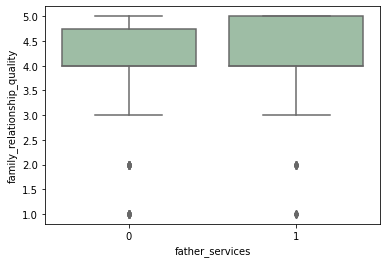

In [77]:

    ax = sns.boxplot(x=renamed['father_services'], y=renamed['family_relationship_quality'], color='#99c2a2')
    plt.show()

## Gender differences

In [78]:
male = renamed.loc[renamed['female'] == 0]
female = renamed.loc[renamed['female'] == 1]

In [79]:
rho = female[["workday_alc_cons", "weekend_alc_cons", "go_out_friends_frequency", "mean_grades", "family_relationship_quality"]].corr()
pval = female[["workday_alc_cons", "weekend_alc_cons", "go_out_friends_frequency", "mean_grades", "family_relationship_quality"]].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(2).astype(str) + p

,workday_alc_cons,weekend_alc_cons,go_out_friends_frequency,mean_grades,family_relationship_quality
workday_alc_cons,1.0***,0.44***,0.13**,-0.0,-0.15***
weekend_alc_cons,0.44***,1.0***,0.28***,0.03,-0.13**
go_out_friends_frequency,0.13**,0.28***,1.0***,-0.04,0.12**
mean_grades,-0.0,0.03,-0.04,1.0***,0.08
family_relationship_quality,-0.15***,-0.13**,0.12**,0.08,1.0***


In [80]:
rho = male[["workday_alc_cons", "weekend_alc_cons", "go_out_friends_frequency", "mean_grades", "family_relationship_quality"]].corr()
pval = male[["workday_alc_cons", "weekend_alc_cons", "go_out_friends_frequency", "mean_grades", "family_relationship_quality"]].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(2).astype(str) + p

,workday_alc_cons,weekend_alc_cons,go_out_friends_frequency,mean_grades,family_relationship_quality
workday_alc_cons,1.0***,0.67***,0.35***,-0.2***,-0.06
weekend_alc_cons,0.67***,1.0***,0.54***,-0.3***,-0.12**
go_out_friends_frequency,0.35***,0.54***,1.0***,-0.16***,0.04
mean_grades,-0.2***,-0.3***,-0.16***,1.0***,0.03
family_relationship_quality,-0.06,-0.12**,0.04,0.03,1.0***


## Age

In [81]:
rho = renamed[['age', 'mother_edu', 'father_edu', 'failures', 'go_out_friends_frequency', 'workday_alc_cons', 'weekend_alc_cons', 'school_absences', 'mean_grades']].corr()
pval = renamed[['age', 'mother_edu', 'father_edu', 'failures', 'go_out_friends_frequency', 'workday_alc_cons', 'weekend_alc_cons', 'school_absences', 'mean_grades']].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(2).astype(str) + p

,age,mother_edu,father_edu,failures,go_out_friends_frequency,workday_alc_cons,weekend_alc_cons,school_absences,mean_grades
age,1.0***,-0.12***,-0.13***,0.28***,0.09**,0.13***,0.07*,0.17***,-0.13***
mother_edu,-0.12***,1.0***,0.64***,-0.16***,0.02,-0.02,-0.04,0.1**,0.21***
father_edu,-0.13***,0.64***,1.0***,-0.17***,0.05,-0.01,0.03,0.07*,0.17***
failures,0.28***,-0.16***,-0.17***,1.0***,0.06,0.09**,0.08**,0.09**,-0.38***
go_out_friends_frequency,0.09**,0.02,0.05,0.06,1.0***,0.25***,0.4***,0.03,-0.09**
workday_alc_cons,0.13***,-0.02,-0.01,0.09**,0.25***,1.0***,0.62***,0.13***,-0.09**
weekend_alc_cons,0.07*,-0.04,0.03,0.08**,0.4***,0.62***,1.0***,0.13***,-0.11***
school_absences,0.17***,0.1**,0.07*,0.09**,0.03,0.13***,0.13***,1.0***,-0.03
mean_grades,-0.13***,0.21***,0.17***,-0.38***,-0.09**,-0.09**,-0.11***,-0.03,1.0***


## School reputation motivation

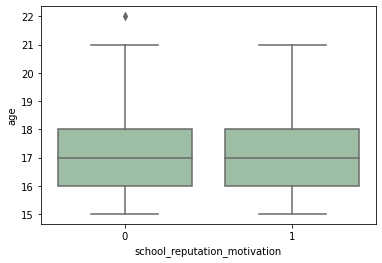

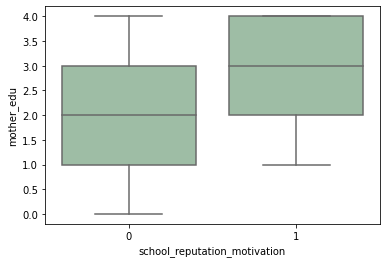

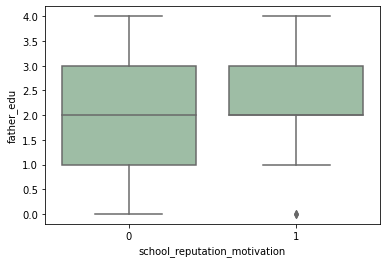

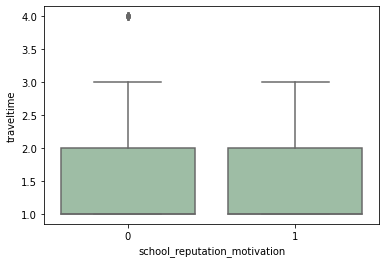

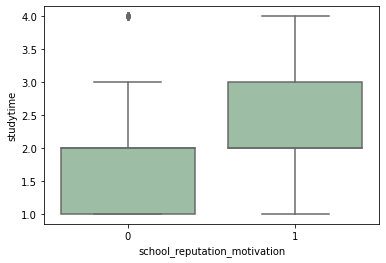

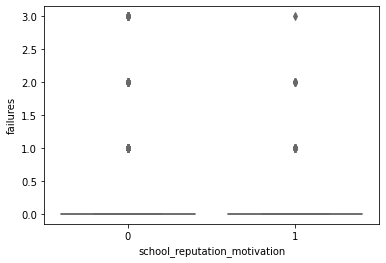

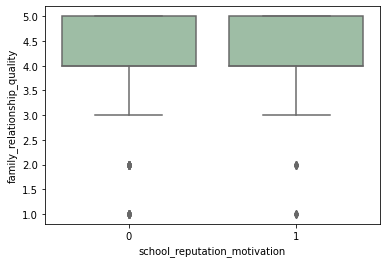

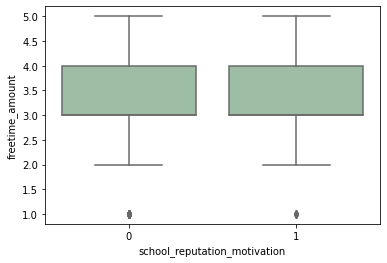

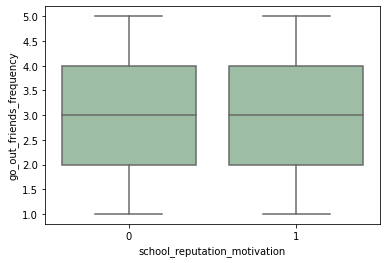

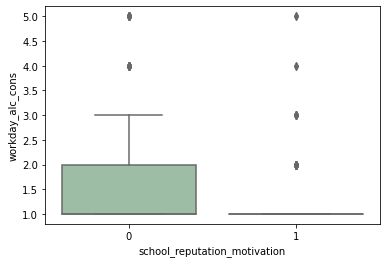

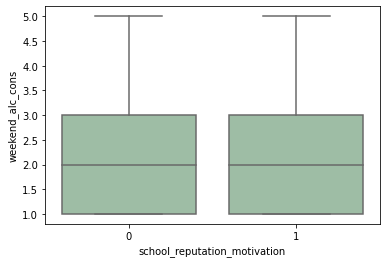

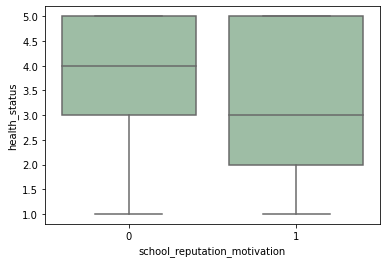

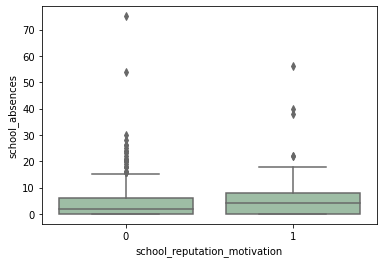

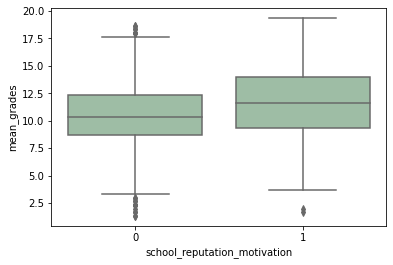

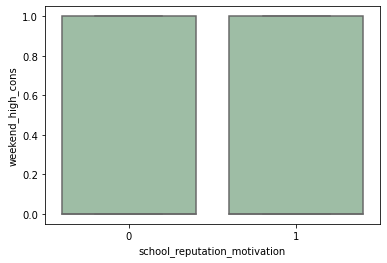

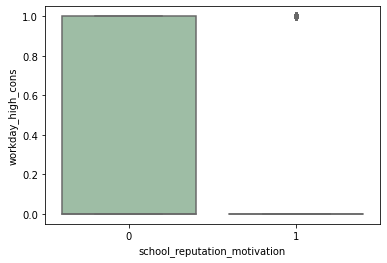

In [82]:
#Related to more parents education, studytime, health_status, school absences, mean grades and less workday alcohol consumption (doesn't affect weekend)
for variable in continuous_mean_grades:
    ax = sns.boxplot(x=renamed['school_reputation_motivation'], y=renamed[variable], color='#99c2a2')
    plt.show()

In [85]:
rho = renamed[['mother_edu', 'father_edu', 'school_absences', 'studytime', 'health_status', 'workday_alc_cons','mean_grades']].corr()
pval = renamed[['mother_edu', 'father_edu', 'school_absences', 'studytime', 'health_status', 'workday_alc_cons', 'mean_grades']].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(2).astype(str) + p

,mother_edu,father_edu,school_absences,studytime,health_status,workday_alc_cons,mean_grades
mother_edu,1.0***,0.64***,0.1**,0.1***,-0.0,-0.02,0.21***
father_edu,0.64***,1.0***,0.07*,0.05,0.04,-0.01,0.17***
school_absences,0.1**,0.07*,1.0***,-0.04,-0.04,0.13***,-0.03
studytime,0.1***,0.05,-0.04,1.0***,-0.05,-0.14***,0.14***
health_status,-0.0,0.04,-0.04,-0.05,1.0***,0.07*,-0.05
workday_alc_cons,-0.02,-0.01,0.13***,-0.14***,0.07*,1.0***,-0.09**
mean_grades,0.21***,0.17***,-0.03,0.14***,-0.05,-0.09**,1.0***


## Workday, weekend, all week and not heavy drinkers

In [97]:
def alcohol_cons_report(df, drinker_type):
    number = len(df)
    workday_mean = round(df['workday_alc_cons'].mean(), 1)
    weekend_mean = round(df['weekend_alc_cons'].mean(), 1)
    print(f'{drinker_type} ({number}) drink an average of {workday_mean} during workdays, and {weekend_mean} during the weekend')

In [98]:
workday_drinkers = renamed.loc[renamed['workday_alc_cons'] > 2].loc[renamed['weekend_alc_cons'] < 3]
weekend_drinkers = renamed.loc[renamed['workday_alc_cons'] <= 2].loc[renamed['weekend_alc_cons'] >= 3]
all_week_drinkers = renamed.loc[renamed['workday_alc_cons'] > 2].loc[renamed['weekend_alc_cons'] >= 3]
not_drinkers = renamed.loc[renamed['workday_alc_cons'] <= 2].loc[renamed['weekend_alc_cons'] < 3]

In [99]:
alcohol_cons_report(workday_drinkers, "Workday drinkers")
alcohol_cons_report(weekend_drinkers, "Weekend drinkers")
alcohol_cons_report(all_week_drinkers, "Drinkers consuming all week")
alcohol_cons_report(not_drinkers, "Student that are not heavy drinkers")

Workday drinkers (6) drink an average of 4.0 during workdays, and 1.5 during the weekend
Weekend drinkers (186) drink an average of 1.5 during workdays, and 3.5 during the weekend
Drinkers consuming all week (74) drink an average of 3.6 during workdays, and 4.3 during the weekend
Student that are not heavy drinkers (396) drink an average of 1.1 during workdays, and 1.4 during the weekend


## Wish higher education 

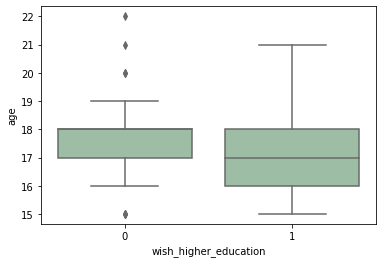

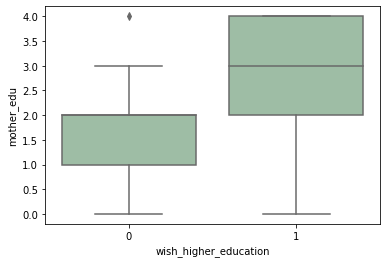

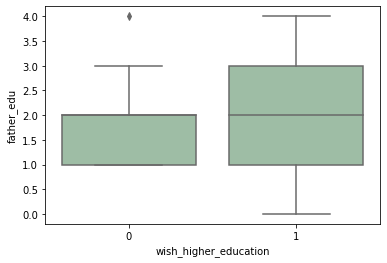

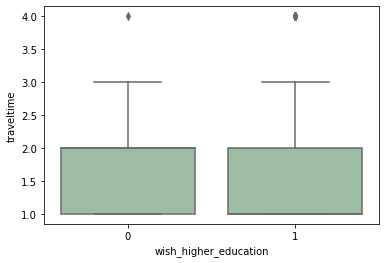

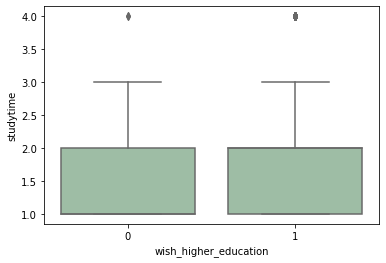

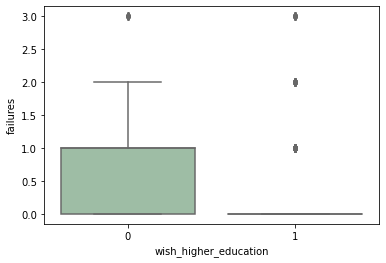

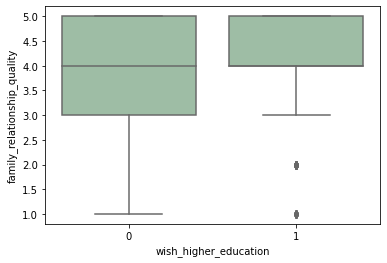

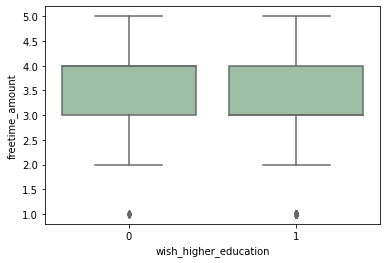

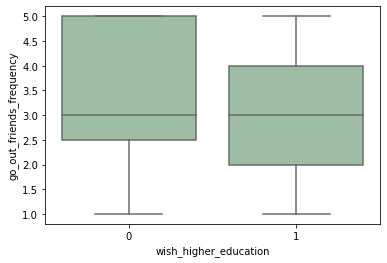

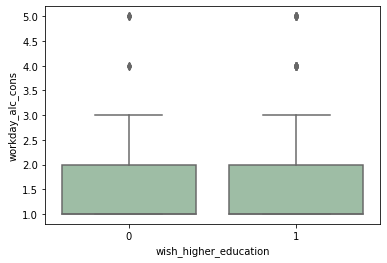

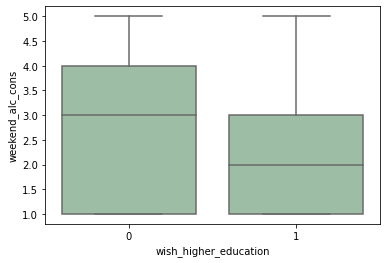

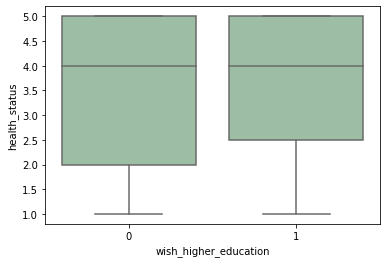

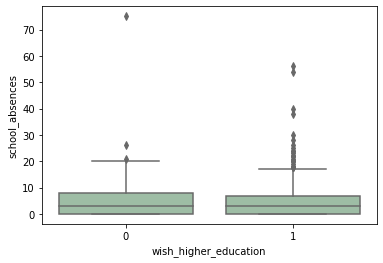

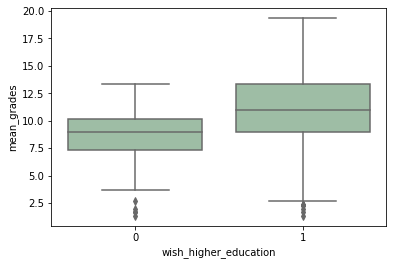

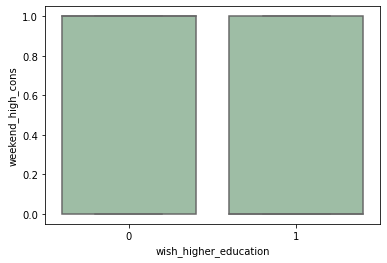

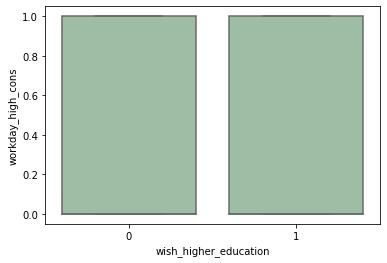

In [100]:
#Linked negatively with age, failures, going out with friends frequency, weekend_alc_cons (not workday)
#Linked positively with parents education, (strongly) family relationship quality, mean grades
for variable in continuous_mean_grades:
    ax = sns.boxplot(x=renamed['wish_higher_education'], y=renamed[variable], color='#99c2a2')
    plt.show()

## Family more than 3

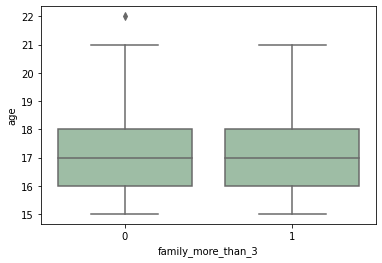

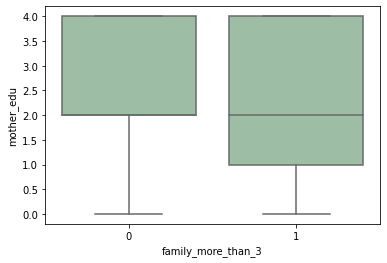

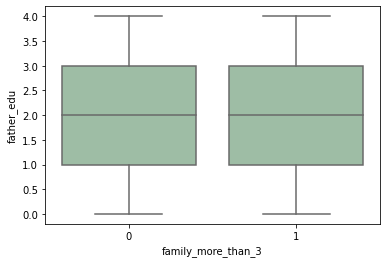

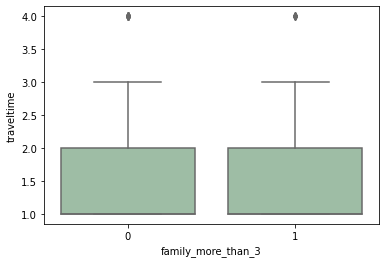

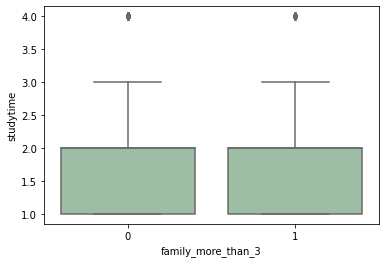

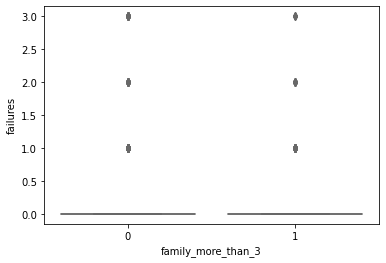

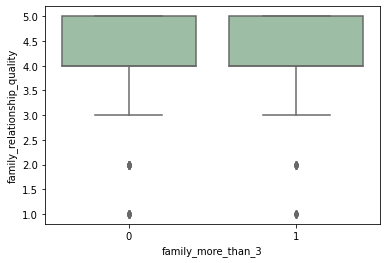

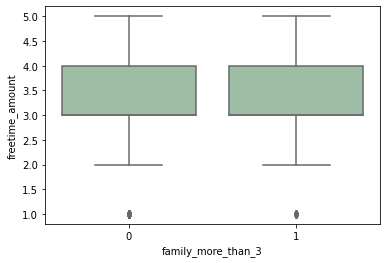

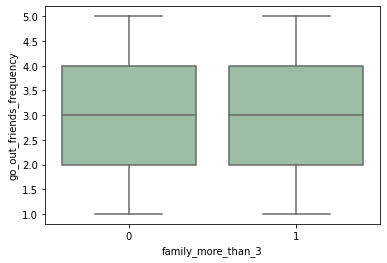

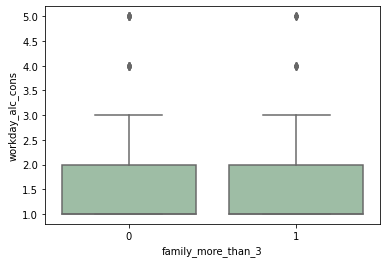

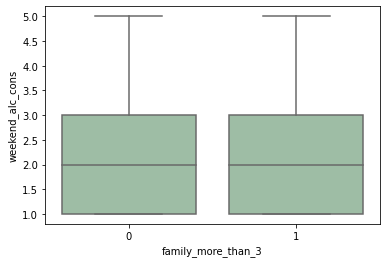

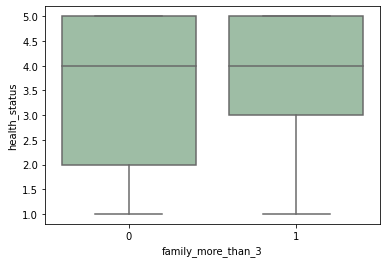

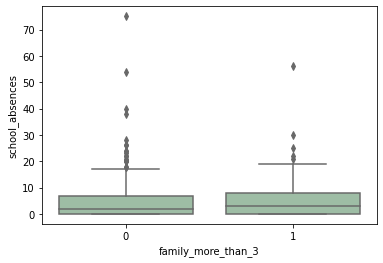

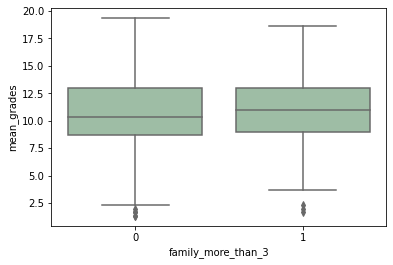

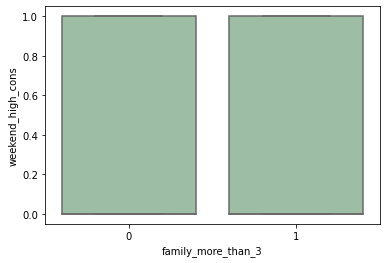

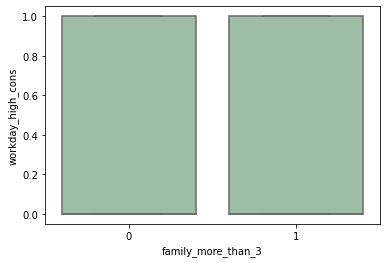

In [101]:
for variable in continuous_mean_grades:
    ax = sns.boxplot(x=renamed['family_more_than_3'], y=renamed[variable], color='#99c2a2')
    plt.show()

## Paid class

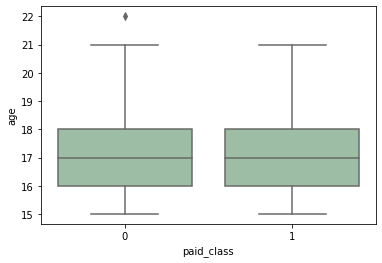

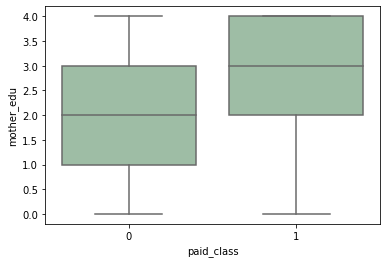

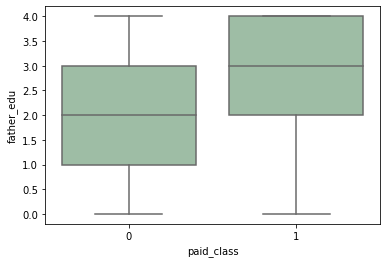

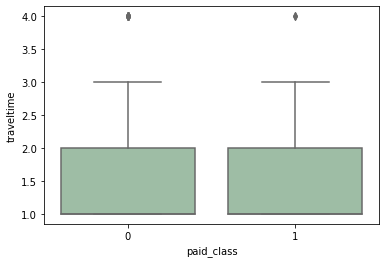

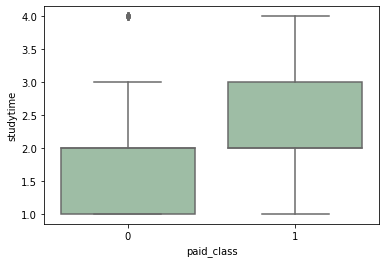

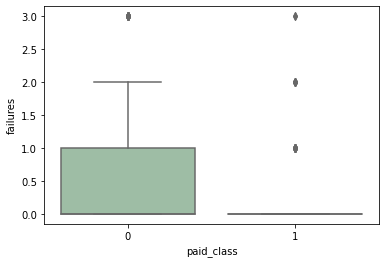

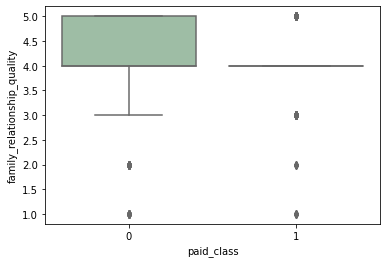

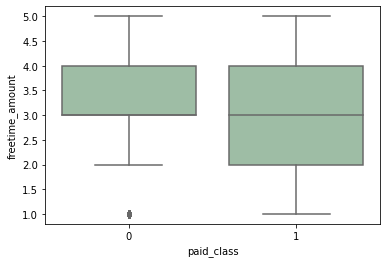

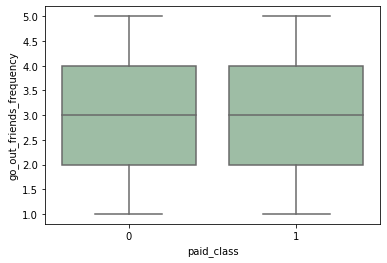

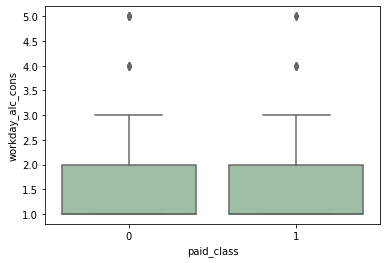

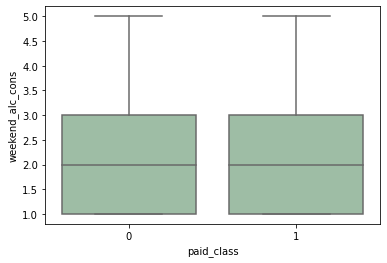

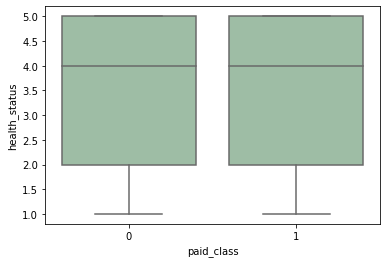

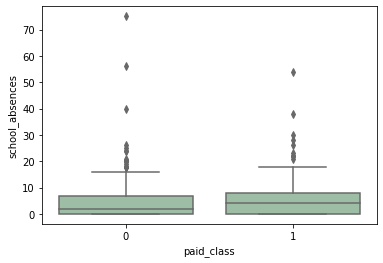

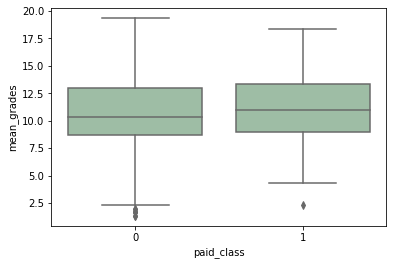

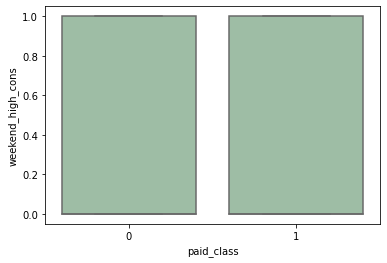

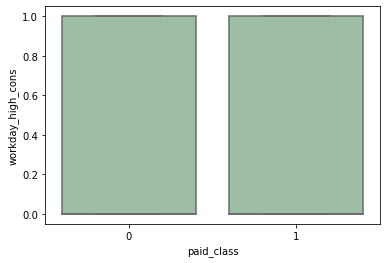

In [107]:
#Positive with mother education (not father), family_relationship_quality, school_absences
#Negative with failures
for variable in continuous_mean_grades:
    ax = sns.boxplot(x=renamed['paid_class'], y=renamed[variable], color='#99c2a2')
    plt.show()

## Nursery school

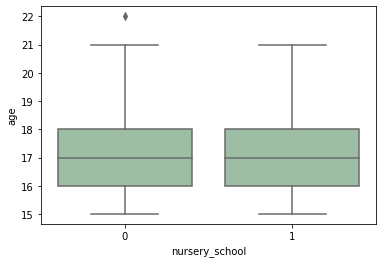

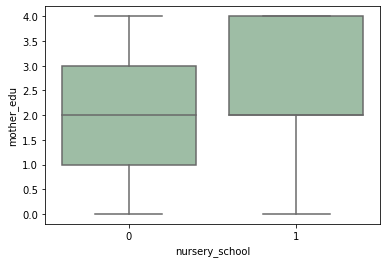

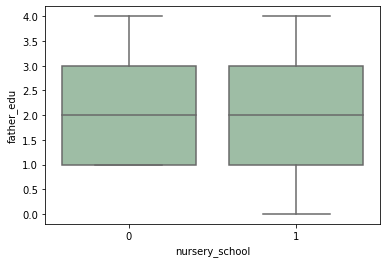

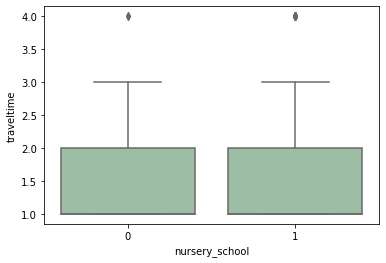

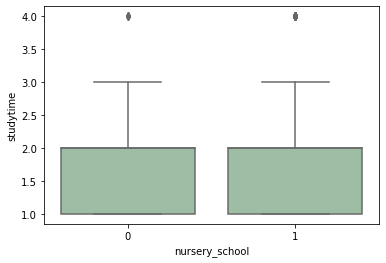

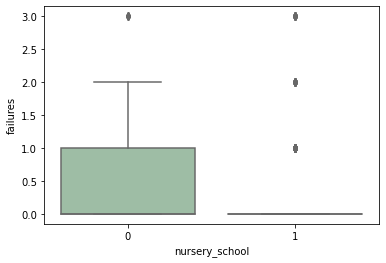

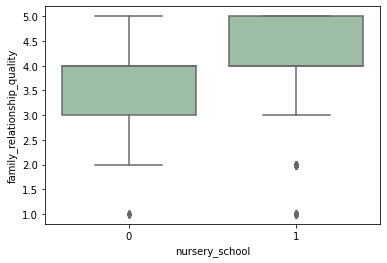

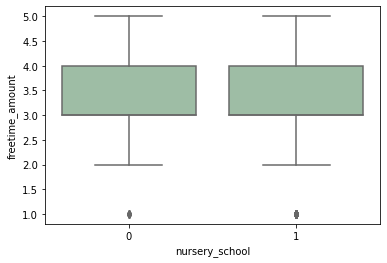

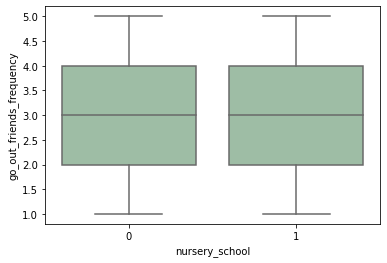

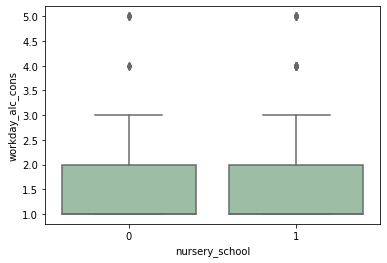

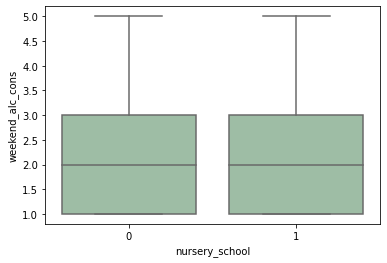

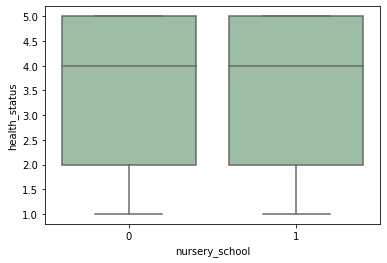

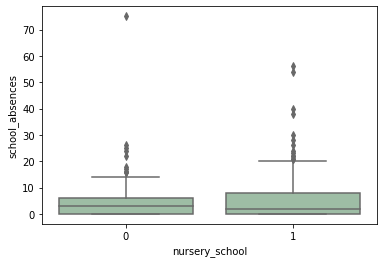

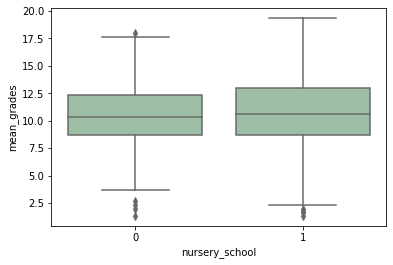

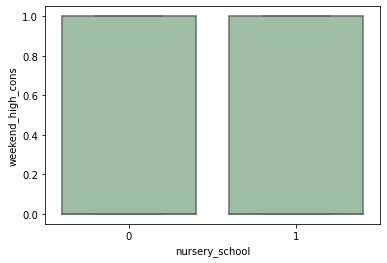

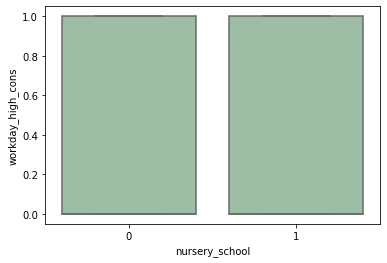

In [102]:
#Positive with mother education (not father), family_relationship_quality, school_absences
#Negative with failures
for variable in continuous_mean_grades:
    ax = sns.boxplot(x=renamed['nursery_school'], y=renamed[variable], color='#99c2a2')
    plt.show()